##### Copyright 2019 The TensorFlow Authors.

In [77]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [78]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic text classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on an IMDB dataset. At the end of the notebook, there is an exercise for you to try, in which you'll train a multi-class classifier to predict the tag for a programming question on Stack Overflow.


In [79]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [80]:
print(tf.__version__)

2.14.0


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.


### Download and explore the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.

In [81]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [82]:
os.listdir(dataset_dir)

['imdbEr.txt', 'README', 'imdb.vocab', 'test', 'train']

In [83]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['unsup',
 'labeledBow.feat',
 'urls_pos.txt',
 'urls_neg.txt',
 'unsupBow.feat',
 'neg',
 'pos',
 'urls_unsup.txt']

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [84]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to `class_a` and `class_b`. These will be the positive and negative movie reviews, which can be found in  `aclImdb/train/pos` and `aclImdb/train/neg`. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [85]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data.

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set).

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [86]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

In [87]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Notice the reviews contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section.

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the `class_names` property on the dataset.


In [88]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [89]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [90]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `tf.keras.layers.TextVectorization` layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: To prevent [training-testing skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [91]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [92]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use your training data when calling adapt (using the test set would leak information).

In [93]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [94]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [95]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [96]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [97]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [98]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create your neural network:

In [99]:
embedding_dim = 16

In [100]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 16)          160000    
                                                                 
 dropout_14 (Dropout)        (None, None, 16)          0         
                                                                 
 global_average_pooling1d_4  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_15 (Dropout)        (None, 16)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
______________

The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  To learn more about embeddings, check out the [Word embeddings](https://www.tensorflow.org/text/guide/word_embeddings) tutorial.
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. The last layer is densely connected with a single output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use `losses.BinaryCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

In [101]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [102]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 37s 58ms/step - loss: 0.6625 - binary_accuracy: 0.6996 - val_loss: 0.6137 - val_binary_accuracy: 0.7706
Epoch 2/10
625/625 [==============================] - 3s 6ms/step - loss: 0.5480 - binary_accuracy: 0.8012 - val_loss: 0.4981 - val_binary_accuracy: 0.8230
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4450 - binary_accuracy: 0.8453 - val_loss: 0.4201 - val_binary_accuracy: 0.8500
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3782 - binary_accuracy: 0.8672 - val_loss: 0.3736 - val_binary_accuracy: 0.8608
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3357 - binary_accuracy: 0.8775 - val_loss: 0.3447 - val_binary_accuracy: 0.8668
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3039 - binary_accuracy: 0.8892 - val_loss: 0.3256 - val_binary_accuracy: 0.8710
Epoch 7/10
625/625 [==============================] - 3s 5ms/s

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [103]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 4s 5ms/step - loss: 0.3101 - binary_accuracy: 0.8732
Loss:  0.3101372718811035
Accuracy:  0.8732399940490723


This fairly naive approach achieves an accuracy of about 86%.

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [104]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

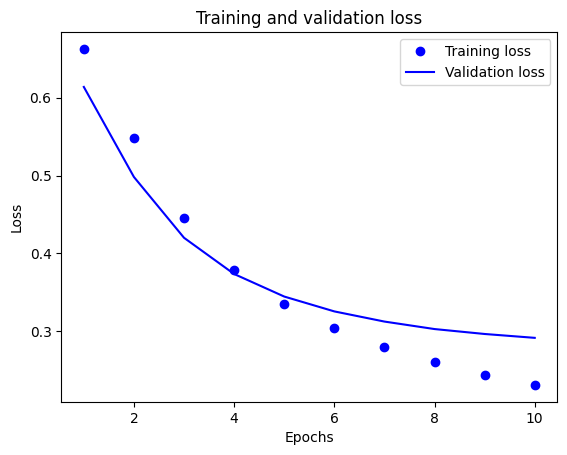

In [105]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

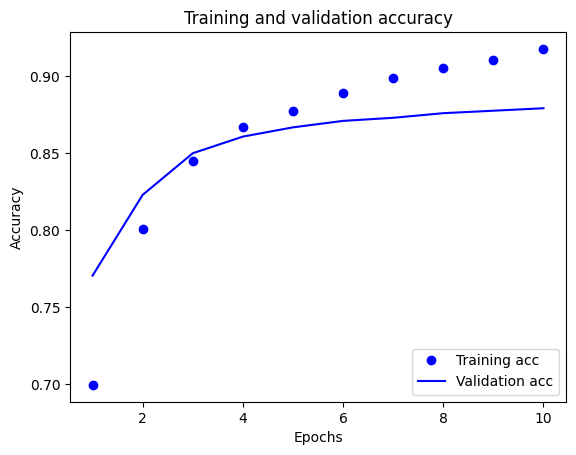

In [106]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the `tf.keras.callbacks.EarlyStopping` callback.

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [107]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 7s 8ms/step - loss: 0.3101 - accuracy: 0.8732
0.8732399940490723


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

In [108]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 94ms/step


array([[0.6097508 ],
       [0.4325259 ],
       [0.34957018]], dtype=float32)

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.

## Exercise: multi-class classification on Stack Overflow questions

This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multi-class classifier to predict the tag of a programming question on [Stack Overflow](http://stackoverflow.com/).

A [dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) has been prepared for you to use containing the body of several thousand programming questions (for example, "How can I sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python.

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Note: To increase the difficulty of the classification problem, occurrences of the words Python, CSharp, JavaScript, or Java in the programming questions have been replaced with the word *blank* (as many questions contain the language they're about).

To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

1. At the top of your notebook, update the code that downloads the IMDB dataset with code to download the [Stack Overflow dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) that has already been prepared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications.

1. Modify the last layer of your model to `Dense(4)`, as there are now four output classes.

1. When compiling the model, change the loss to `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)`. This is the correct loss function to use for a multi-class classification problem, when the labels for each class are integers (in this case, they can be 0, *1*, *2*, or *3*). In addition, change the metrics to `metrics=['accuracy']`, since this is a multi-class classification problem (`tf.metrics.BinaryAccuracy` is only used for binary classifiers).

1. When plotting accuracy over time, change `binary_accuracy` and `val_binary_accuracy` to `accuracy` and `val_accuracy`, respectively.

1. Once these changes are complete, you will be able to train a multi-class classifier.

## Learning more

This tutorial introduced text classification from scratch. To learn more about the text classification workflow in general, check out the [Text classification guide](https://developers.google.com/machine-learning/guides/text-classification/) from Google Developers.


# Codeathon 2

# 1. Update the code that downloads the IMDB dataset with code to download the Stack Overflow dataset that has already been prepared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications.

In [109]:
# update dataset

# copy link from above
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

# directory name
directory_name = "stack_overflow_16k"

dataset = tf.keras.utils.get_file(directory_name, url,
                                  untar = True, cache_dir = '.',
                                  cache_subdir = directory_name,
                                  extract = True)

dataset_dir = os.path.join(os.path.dirname(dataset))

6053168/6053168 [==============================] - 1s 0us/step


In [110]:
# list dir
os.listdir(dataset_dir)

['stack_overflow_16k.tar.gz', 'README.md', 'test', 'train']

In [111]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['python', 'java', 'javascript', 'csharp']

In [112]:
sample_file_2 = os.path.join(train_dir, 'java/0.txt')
with open(sample_file_2) as f:
  print(f.read())

"how to download .msi file in blank i want to download .msi file using blank.  i have tried to download file using following code..printwriter out = null;.fileinputstream filetodownload = null;.bufferedreader bufferedreader = null;.try {.        out = response.getwriter();.        filetodownload = new fileinputstream(download_directory + file_name);.        bufferedreader = new bufferedreader(new inputstreamreader(filetodownload));..        //response.setcontenttype(""application/text"");.        //response.setcontenttype(""application/x-msi"");.        //response.setcontenttype(""application/msi"");.        //response.setcontenttype(""octet-stream"");.        response.setcontenttype(""application/octet-stream"");.        //response.setcontenttype(""application/x-7z-compressed"");.        //response.setcontenttype(""application/zip"");.        response.setheader(""content-disposition"",""attachment; filename="" +file_name );.        response.setcontentlength(filetodownload.available())

In [113]:
remove_dir = os.path.join(dataset_dir, 'stack_overflow_16k.tar.gz')
# shutil.rmtree(remove_dir_2)
!rm -rf {remove_dir}

In [114]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [115]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(10):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

In [116]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [117]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'validation',
    seed = seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [118]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/test',
    batch_size = batch_size)

Found 8000 files belonging to 4 classes.


In [119]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [120]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length)

In [121]:
# Make a text-only dataset (without labels), then call adapt

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [122]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [123]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Question:", first_review)
print("Label:", raw_train_ds.class_names[first_label])
print("Vectorized question:", vectorize_text(first_review, first_label))

Question: tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of e

In [124]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  scissors
 313 --->  source
Vocabulary size: 10000


In [125]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [126]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

# 2. Modify the last layer of your model to Dense(4), as there are now four output classes.

In [127]:
embedding_dim = 16

In [128]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 16)          160016    
                                                                 
 dropout_16 (Dropout)        (None, None, 16)          0         
                                                                 
 global_average_pooling1d_5  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_17 (Dropout)        (None, 16)                0         
                                                                 
 dense_13 (Dense)            (None, 4)                 68        
                                                                 
Total params: 160084 (625.33 KB)
Trainable params: 160084 (625.33 KB)
Non-trainable params: 0 (0.00 Byte)
______________

# 3. When compiling the model, change the loss to tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True). This is the correct loss function to use for a multi-class classification problem, when the labels for each class are integers (in this case, they can be 0, 1, 2, or 3). In addition, change the metrics to metrics=['accuracy'], since this is a multi-class classification problem (tf.metrics.BinaryAccuracy is only used for binary classifiers).



In [129]:
model.compile(loss = losses.SparseCategoricalCrossentropy(from_logits = True),
              optimizer = 'adam',
              metrics=['accuracy'])

In [130]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs)

Epoch 1/20
200/200 [==============================] - 16s 78ms/step - loss: 1.3794 - accuracy: 0.3339 - val_loss: 1.3691 - val_accuracy: 0.4950
Epoch 2/20
200/200 [==============================] - 1s 5ms/step - loss: 1.3519 - accuracy: 0.4502 - val_loss: 1.3310 - val_accuracy: 0.5312
Epoch 3/20
200/200 [==============================] - 1s 5ms/step - loss: 1.3016 - accuracy: 0.5303 - val_loss: 1.2717 - val_accuracy: 0.5806
Epoch 4/20
200/200 [==============================] - 1s 6ms/step - loss: 1.2325 - accuracy: 0.5872 - val_loss: 1.1992 - val_accuracy: 0.6206
Epoch 5/20
200/200 [==============================] - 1s 6ms/step - loss: 1.1539 - accuracy: 0.6336 - val_loss: 1.1238 - val_accuracy: 0.6656
Epoch 6/20
200/200 [==============================] - 1s 4ms/step - loss: 1.0763 - accuracy: 0.6812 - val_loss: 1.0511 - val_accuracy: 0.7050
Epoch 7/20
200/200 [==============================] - 1s 4ms/step - loss: 1.0036 - accuracy: 0.7084 - val_loss: 0.9851 - val_accuracy: 0.7237
Epoc

In [131]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 1s 4ms/step - loss: 0.6388 - accuracy: 0.7828
Loss:  0.6387518048286438
Accuracy:  0.7827500104904175


# When plotting accuracy over time, change binary_accuracy and val_binary_accuracy to accuracy and val_accuracy, respectively.

In [132]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

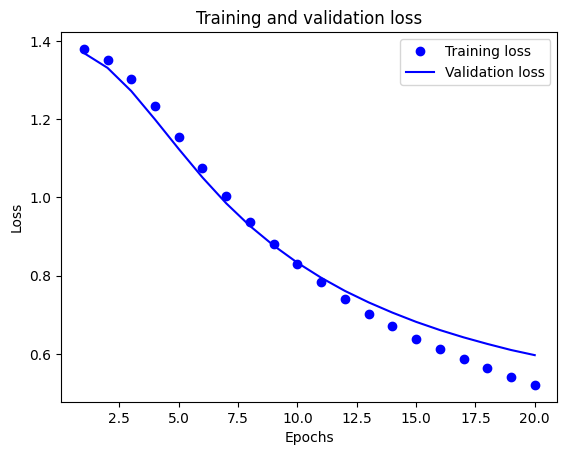

In [133]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label = 'Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

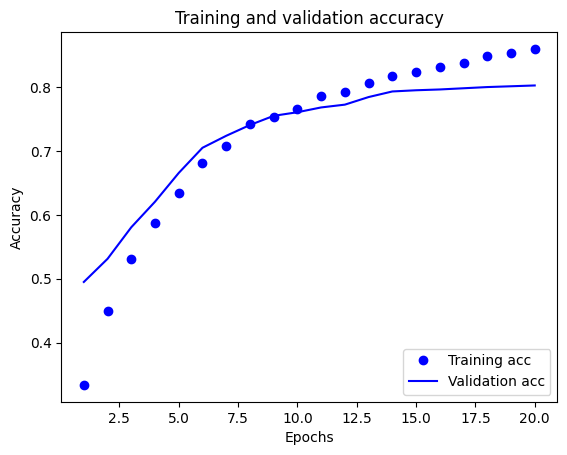

In [134]:
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')

plt.show()

# 5. Once these changes are complete, you will be able to train a multi-class classifier.

In [135]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 2s 6ms/step - loss: 0.6388 - accuracy: 0.7828
0.7827500104904175


# Transformer Model

In [136]:
import tensorflow as tf
from tensorflow.keras import layers
import re
import string
import keras

In [137]:
# Transformer and TokenAndPositionEmbedding classes

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# data preprocessing

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

os.listdir(dataset_dir)

train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

# remove additional folders

remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

# raw training

batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

# raw validation

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

# raw testing

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)


# custom standardization for Transformer input requirements

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

# max features and sequence length
max_features = 20000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# vectorize data
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

# create Transformer model

embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# prepare final datasets
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# model creation using Transformer

inputs = layers.Input(shape=(sequence_length,))
embedding_layer = TokenAndPositionEmbedding(sequence_length, max_features, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)  # Changed for binary classification

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# model compilation and training

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# train model
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# evaluate model
loss, accuracy = model.evaluate(test_ds)
print("Loss:", loss)
print("Accuracy:", accuracy)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Epoch 1/10
625/625 [==============================] - 50s 74ms/step - loss: 0.4103 - accuracy: 0.8025 - val_loss: 0.2805 - val_accuracy: 0.8828
Epoch 2/10
625/625 [==============================] - 22s 36ms/step - loss: 0.2070 - accuracy: 0.9216 - val_loss: 0.2922 - val_accuracy: 0.8802
Epoch 3/10
625/625 [==============================] - 16s 26ms/step - loss: 0.1369 - accuracy: 0.9495 - val_loss: 0.3827 - val_accuracy: 0.8780
Epoch 4/10
625/625 [==============================] - 13s 21ms/step - loss: 0.0762 - accuracy: 0.9763 - val_loss: 0.5394 - val_accuracy: 0.8558
Epoch 5/10
625/625 [==============================] - 15s 24ms/step - loss: 0.0480 - accuracy: 0.9861 - val_loss: 0.5629 - val_accuracy: 0.8688
Epoch 6/10
625/625 [==============================] - 13s 20ms/step - loss: 0.0322 - accu

In [138]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

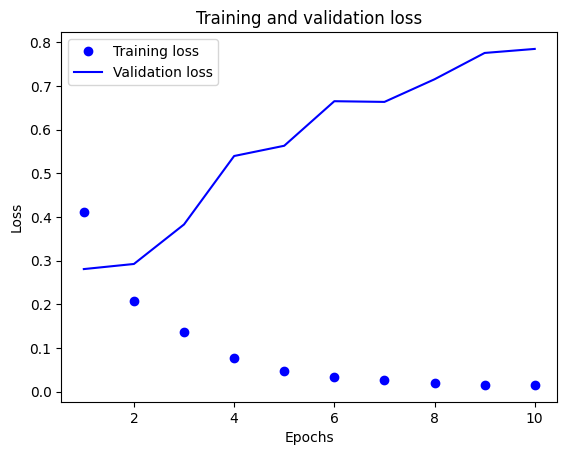

In [139]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label = 'Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

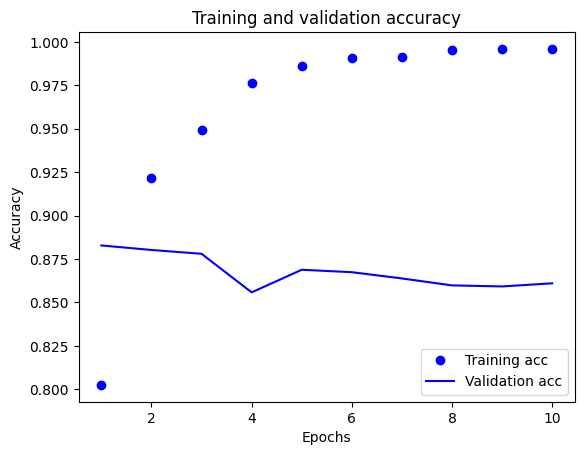

In [140]:
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')

plt.show()

The model appears to be suffering from overfitting, so I will attempt to address the issue by making some adjustments.

# Transformer Round 2:

Adding L2 Regularization.

In [141]:
from tensorflow.keras import layers, regularizers, callbacks

In [142]:
# Hyperparameters
embed_dim = 32  # Embedding size for each token
num_heads = 2   # Number of attention heads
ff_dim = 32     # Hidden layer size in feed forward network inside transformer
dropout_rate = 0.5  # Increase dropout rate to prevent overfitting
l2_reg = 0.01  # L2 regularization factor

# Vectorize text function as before

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Prepare final datasets
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Configure the datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model creation using Transformer with additional dropout and regularization

inputs = layers.Input(shape=(sequence_length,))
embedding_layer = TokenAndPositionEmbedding(sequence_length, max_features, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, rate=dropout_rate)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(dropout_rate)(x)
# Add L2 regularization to the dense layer
x = layers.Dense(20, activation="relu", kernel_regularizer=regularizers.l2(l2_reg))(x)
x = layers.Dropout(dropout_rate)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Model compilation

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Model training with early stopping
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping])

# Evaluate model
loss, accuracy = model.evaluate(test_ds)
print("Loss:", loss)
print("Accuracy:", accuracy)

Epoch 1/10
625/625 [==============================] - 52s 74ms/step - loss: 0.6370 - accuracy: 0.6973 - val_loss: 0.3446 - val_accuracy: 0.8676
Epoch 2/10
625/625 [==============================] - 8s 13ms/step - loss: 0.2952 - accuracy: 0.9032 - val_loss: 0.3405 - val_accuracy: 0.8682
Epoch 3/10
625/625 [==============================] - 8s 13ms/step - loss: 0.1966 - accuracy: 0.9439 - val_loss: 0.3822 - val_accuracy: 0.8792
Epoch 4/10
625/625 [==============================] - 9s 14ms/step - loss: 0.1446 - accuracy: 0.9621 - val_loss: 0.5180 - val_accuracy: 0.8712
Epoch 5/10
782/782 [==============================] - 7s 9ms/step - loss: 0.3852 - accuracy: 0.8504
Loss: 0.3852328658103943
Accuracy: 0.8504400253295898


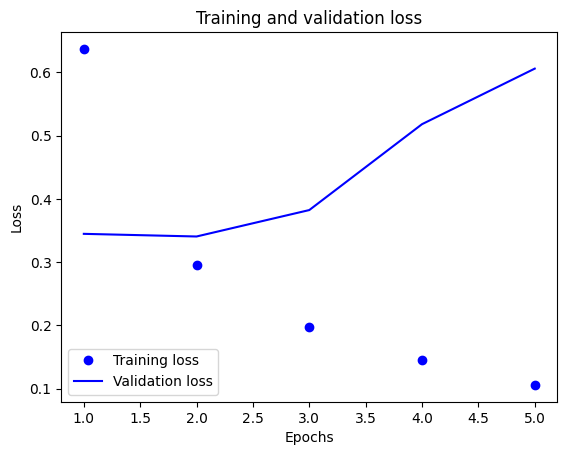

In [143]:
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label = 'Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

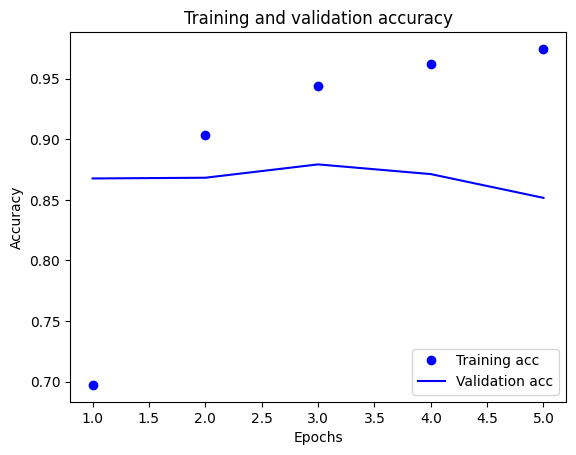

In [144]:
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')

plt.show()

Overfitting still an issue.

# Adding a LR Scheduler:

In [145]:
# adding a learning rate scheduler

# Define a schedule for the learning rate decay
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Learning Rate Scheduler callback
lr_scheduler = callbacks.LearningRateScheduler(scheduler)

# Model compilation with an initial learning rate
initial_learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Model training with early stopping and learning rate scheduler
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate model
loss, accuracy = model.evaluate(test_ds)
print("Loss:", loss)
print("Accuracy:", accuracy)


Epoch 1/10
625/625 [==============================] - 50s 74ms/step - loss: 0.1967 - accuracy: 0.9445 - val_loss: 0.3818 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 2/10
625/625 [==============================] - 9s 15ms/step - loss: 0.1420 - accuracy: 0.9610 - val_loss: 0.4935 - val_accuracy: 0.8734 - lr: 0.0010
Epoch 3/10
625/625 [==============================] - 7s 12ms/step - loss: 0.1051 - accuracy: 0.9748 - val_loss: 0.6005 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 4/10
782/782 [==============================] - 4s 5ms/step - loss: 0.4506 - accuracy: 0.8493
Loss: 0.4505825638771057
Accuracy: 0.8493199944496155


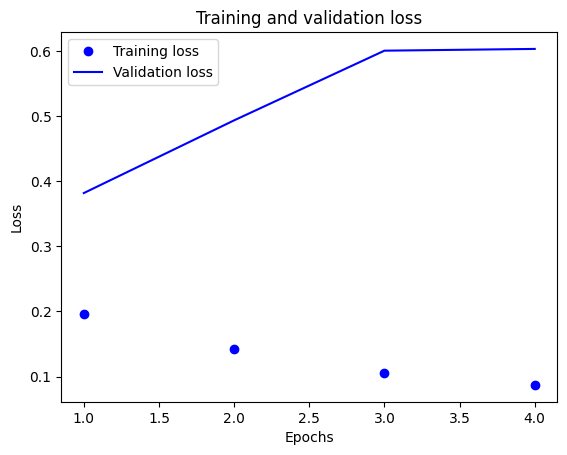

In [146]:
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label = 'Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

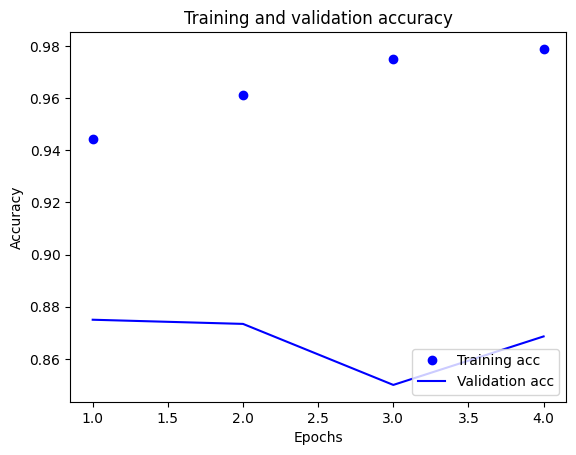

In [147]:
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')

plt.show()

# LR Scheduler and No Early Stopping:

In [148]:
# adding a learning rate scheduler

# Define a schedule for the learning rate decay
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Learning Rate Scheduler callback
lr_scheduler = callbacks.LearningRateScheduler(scheduler)

# Model compilation with an initial learning rate
initial_learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Model training with early stopping and learning rate scheduler
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[lr_scheduler]
)

# Evaluate model
loss, accuracy = model.evaluate(test_ds)
print("Loss:", loss)
print("Accuracy:", accuracy)

Epoch 1/10
625/625 [==============================] - 49s 73ms/step - loss: 0.1473 - accuracy: 0.9597 - val_loss: 0.4718 - val_accuracy: 0.8766 - lr: 0.0010
Epoch 2/10
625/625 [==============================] - 9s 14ms/step - loss: 0.1022 - accuracy: 0.9765 - val_loss: 0.6098 - val_accuracy: 0.8692 - lr: 0.0010
Epoch 3/10
625/625 [==============================] - 7s 11ms/step - loss: 0.0751 - accuracy: 0.9843 - val_loss: 0.6761 - val_accuracy: 0.8628 - lr: 0.0010
Epoch 4/10
625/625 [==============================] - 7s 11ms/step - loss: 0.0598 - accuracy: 0.9884 - val_loss: 0.7916 - val_accuracy: 0.8582 - lr: 0.0010
Epoch 5/10
625/625 [==============================] - 11s 18ms/step - loss: 0.0618 - accuracy: 0.9868 - val_loss: 0.7105 - val_accuracy: 0.8560 - lr: 0.0010
Epoch 6/10
625/625 [==============================] - 14s 22ms/step - loss: 0.0402 - accuracy: 0.9930 - val_loss: 0.9022 - val_accuracy: 0.8620 - lr: 9.0484e-04
Epoch 7/10
625/625 [==============================] - 7s 

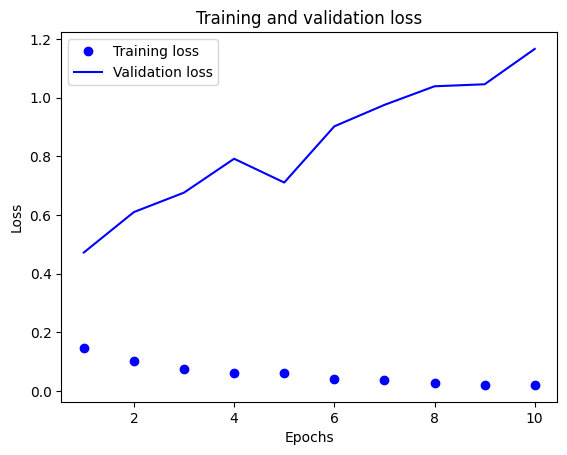

In [149]:
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label = 'Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

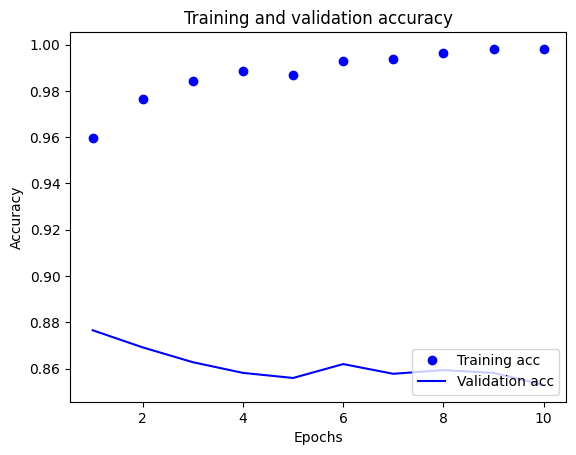

In [150]:
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')

plt.show()

These methods were not as succesful as I had hoped, so I will begin again with my Transformer model and a different approach.

# Restarting Transformer Model Using a 1D Convolutional Layer

In [152]:
# Transformer and TokenAndPositionEmbedding classes

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# data preprocessing

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

os.listdir(dataset_dir)

train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

# remove additional folders

remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

# raw training

batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

# raw validation

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

# raw testing

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)


# custom standardization for Transformer input requirements

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

# max features and sequence length
max_features = 20000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# vectorize data
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

# define 1D Convolutional layer
num_filters = 32
kernel_size = 3

conv_layer = layers.Conv1D(num_filters, kernel_size, activation='relu')

# create Transformer model

embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# prepare final datasets
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# model creation using Transformer

inputs = layers.Input(shape=(sequence_length,))
embedding_layer = TokenAndPositionEmbedding(sequence_length, max_features, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = conv_layer(x)  # add in the convolutional layer
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)  # Changed for binary classification

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# model compilation and training

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# train model
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# evaluate model
loss, accuracy = model.evaluate(test_ds)
print("Loss:", loss)
print("Accuracy:", accuracy)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Epoch 1/10
625/625 [==============================] - 58s 79ms/step - loss: 0.4315 - accuracy: 0.7808 - val_loss: 0.2964 - val_accuracy: 0.8816
Epoch 2/10
625/625 [==============================] - 21s 34ms/step - loss: 0.1965 - accuracy: 0.9276 - val_loss: 0.2941 - val_accuracy: 0.8792
Epoch 3/10
625/625 [==============================] - 18s 30ms/step - loss: 0.1135 - accuracy: 0.9603 - val_loss: 0.3672 - val_accuracy: 0.8820
Epoch 4/10
625/625 [==============================] - 13s 22ms/step - loss: 0.0661 - accuracy: 0.9787 - val_loss: 0.5918 - val_accuracy: 0.8598
Epoch 5/10
625/625 [==============================] - 14s 22ms/step - loss: 0.0402 - accuracy: 0.9873 - val_loss: 0.5753 - val_accuracy: 0.8744
Epoch 6/10
625/625 [==============================] - 13s 21ms/step - loss: 0.0244 - accu

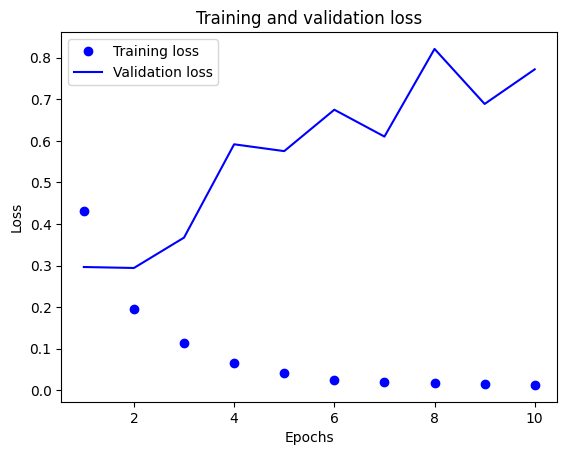

In [153]:
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label = 'Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

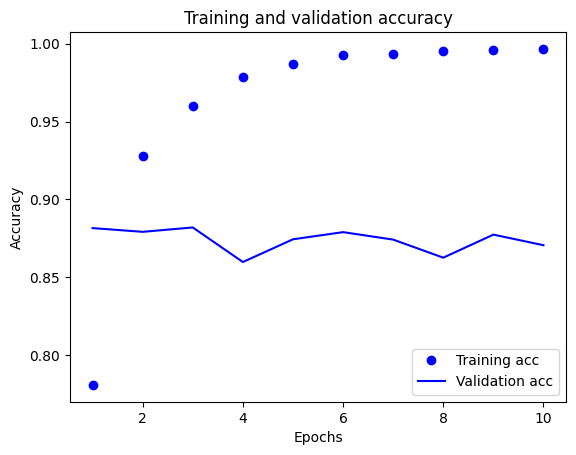

In [154]:
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')

plt.show()

# Increasing the feed-forward hidden layer size (ff_dim) on 1D Convolutional Layer Model

In [156]:
# Transformer and TokenAndPositionEmbedding classes

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# data preprocessing

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

os.listdir(dataset_dir)

train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

# remove additional folders

remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

# raw training

batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

# raw validation

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

# raw testing

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)


# custom standardization for Transformer input requirements

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

# max features and sequence length
max_features = 20000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# vectorize data
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

# define 1D Convolutional layer
num_filters = 32
kernel_size = 3

conv_layer = layers.Conv1D(num_filters, kernel_size, activation='relu')

# create Transformer model

embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# prepare final datasets
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# model creation using Transformer

inputs = layers.Input(shape=(sequence_length,))
embedding_layer = TokenAndPositionEmbedding(sequence_length, max_features, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = conv_layer(x)  # add in the convolutional layer
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)  # Changed for binary classification

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# model compilation and training

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# train model
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# evaluate model
loss, accuracy = model.evaluate(test_ds)
print("Loss:", loss)
print("Accuracy:", accuracy)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Epoch 1/10
625/625 [==============================] - 54s 77ms/step - loss: 0.4313 - accuracy: 0.7804 - val_loss: 0.2893 - val_accuracy: 0.8834
Epoch 2/10
625/625 [==============================] - 23s 37ms/step - loss: 0.1988 - accuracy: 0.9258 - val_loss: 0.2935 - val_accuracy: 0.8772
Epoch 3/10
625/625 [==============================] - 17s 27ms/step - loss: 0.1231 - accuracy: 0.9560 - val_loss: 0.3707 - val_accuracy: 0.8830
Epoch 4/10
625/625 [==============================] - 14s 22ms/step - loss: 0.0631 - accuracy: 0.9800 - val_loss: 0.4354 - val_accuracy: 0.8742
Epoch 5/10
625/625 [==============================] - 14s 22ms/step - loss: 0.0432 - accuracy: 0.9858 - val_loss: 0.5231 - val_accuracy: 0.8788
Epoch 6/10
625/625 [==============================] - 13s 21ms/step - loss: 0.0332 - accu

# Smaller feed-forward hidden layer size and decrease the learning rate:

In [157]:
# Transformer and TokenAndPositionEmbedding classes

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# data preprocessing

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

os.listdir(dataset_dir)

train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

# remove additional folders

remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

# raw training

batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

# raw validation

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

# raw testing

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)


# custom standardization for Transformer input requirements

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

# max features and sequence length
max_features = 20000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# vectorize data
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

# define 1D Convolutional layer
num_filters = 32
kernel_size = 3

conv_layer = layers.Conv1D(num_filters, kernel_size, activation='relu')

# create Transformer model

embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 64  # Hidden layer size in feed forward network inside transformer

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# prepare final datasets
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# model creation using Transformer

inputs = layers.Input(shape=(sequence_length,))
embedding_layer = TokenAndPositionEmbedding(sequence_length, max_features, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = conv_layer(x)  # add in the convolutional layer
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)  # Changed for binary classification

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# model compilation and training

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

#model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# train model
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# evaluate model
loss, accuracy = model.evaluate(test_ds)
print("Loss:", loss)
print("Accuracy:", accuracy)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Epoch 1/10
625/625 [==============================] - 54s 79ms/step - loss: 0.6382 - accuracy: 0.6292 - val_loss: 0.4756 - val_accuracy: 0.8186
Epoch 2/10
625/625 [==============================] - 26s 42ms/step - loss: 0.3562 - accuracy: 0.8533 - val_loss: 0.3315 - val_accuracy: 0.8546
Epoch 3/10
625/625 [==============================] - 17s 27ms/step - loss: 0.2359 - accuracy: 0.9107 - val_loss: 0.2895 - val_accuracy: 0.8840
Epoch 4/10
625/625 [==============================] - 14s 23ms/step - loss: 0.1650 - accuracy: 0.9421 - val_loss: 0.3192 - val_accuracy: 0.8766
Epoch 5/10
625/625 [==============================] - 14s 22ms/step - loss: 0.1216 - accuracy: 0.9617 - val_loss: 0.3408 - val_accuracy: 0.8814
Epoch 6/10
625/625 [==============================] - 13s 21ms/step - loss: 0.0911 - accu

# Increase Number of Attention Heads and Add L2 Reg

In [158]:
# Transformer and TokenAndPositionEmbedding classes

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# data preprocessing

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

os.listdir(dataset_dir)

train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

# remove additional folders

remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

# raw training

batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

# raw validation

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

# raw testing

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)


# custom standardization for Transformer input requirements

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

# max features and sequence length
max_features = 20000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# vectorize data
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

# define 1D Convolutional layer
num_filters = 32
kernel_size = 3

conv_layer = layers.Conv1D(num_filters, kernel_size, activation='relu')

# create Transformer model

embed_dim = 32  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 64  # Hidden layer size in feed forward network inside transformer

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# prepare final datasets
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# model creation using Transformer

inputs = layers.Input(shape=(sequence_length,))
embedding_layer = TokenAndPositionEmbedding(sequence_length, max_features, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = conv_layer(x)  # add in the convolutional layer
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
# updated
x = layers.Dense(ff_dim, activation="relu",kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)  # Changed for binary classification

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# model compilation and training

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

#model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# train model
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# evaluate model
loss, accuracy = model.evaluate(test_ds)
print("Loss:", loss)
print("Accuracy:", accuracy)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Epoch 1/10
625/625 [==============================] - 766s 1s/step - loss: 0.9647 - accuracy: 0.6281 - val_loss: 0.7125 - val_accuracy: 0.8272
Epoch 2/10
625/625 [==============================] - 26s 42ms/step - loss: 0.5349 - accuracy: 0.8606 - val_loss: 0.4697 - val_accuracy: 0.8610
Epoch 3/10
625/625 [==============================] - 17s 27ms/step - loss: 0.3484 - accuracy: 0.9139 - val_loss: 0.3858 - val_accuracy: 0.8810
Epoch 4/10
625/625 [==============================] - 14s 22ms/step - loss: 0.2378 - accuracy: 0.9461 - val_loss: 0.4127 - val_accuracy: 0.8624
Epoch 5/10
625/625 [==============================] - 14s 22ms/step - loss: 0.1726 - accuracy: 0.9643 - val_loss: 0.3868 - val_accuracy: 0.8776
Epoch 6/10
625/625 [==============================] - 13s 22ms/step - loss: 0.1285 - accur

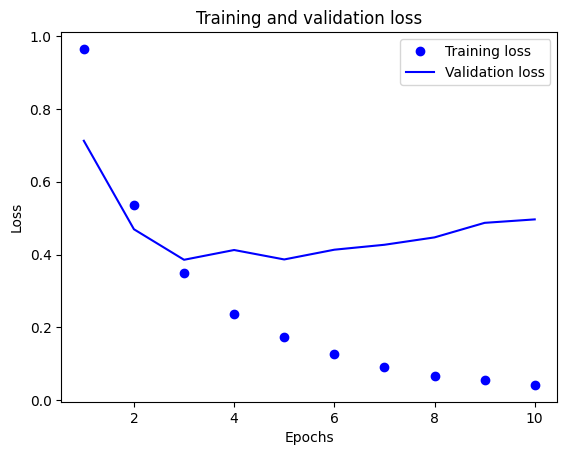

In [159]:
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label = 'Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

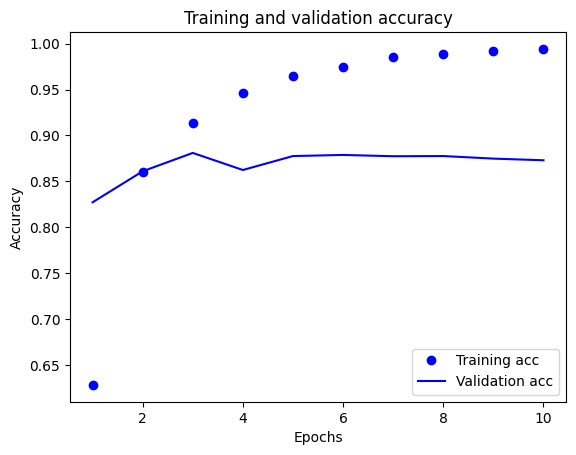

In [160]:
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')

plt.show()

# Conclusion

Throughout this exercise, I made several changes to my model architecture and parameters in order to attempt to increase the accuracy of the model.

I began by creating a Transformer-based architecture and introduced several key improvements. These included the addition of L2 regularization to mitigate overfitting, the implementation of a Learning Rate Scheduler to adapt the learning rate during training, and the introduction of Early Stopping to prevent overfitting. However, when my validation accuracy did not meet expectations, I opted for a different approach.

I restarted with the Transformer model and incorporated a 1D convolutional layer and aimed to capture local patterns in the text data. I further increased the feed-forward hidden layer size to enable the model to capture more intricate data patterns. To improve convergence, I decreased the learning rate. In addition, I raised the number of attention heads to enhance the model's ability to capture global dependencies in the data. Finally, I reintroduced L2 regularization to maintain robustness in the face of increased complexity.

Ultimately, I was not able to surpass the 87% accuracy of the original model. My model largely suffered from overfitting, which I was not able to entirely overcome despite various efforts through changes made to architecture and parameters. Moving forward, I would consider experimenting with more advanced pre-trained language models such as BERT or GPT-3 and fine-tuning them on this specific classification task. Additionally, I can further augment the data, tune the hyperparameters, and try different ensemble methods in order to continue improving the accuracy of the model.


